## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [102]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.discriminant_analysis
import sklearn.svm
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
import math
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [36]:
df = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [37]:
df["disease"] = df["diagnosis"].map({"Disease":True, "No Disease": False})
df = df.drop("diagnosis",axis=1)
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,disease
0,Magnolia Cassin,60,1,1,117,230,1,160,False
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,True
2,Miles Wolf,62,0,3,130,263,1,97,False
3,Mikaila Block,43,1,1,115,303,1,181,True
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,True


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [67]:
X = df[["age","chol"]]
y = df["disease"]


logistic_pipeline = Pipeline([
  ("logistic_regression", LogisticRegression())]
)

logistic_pipeline.fit(X,y)

Pipeline(steps=[('logistic_regression', LogisticRegression())])

In [68]:
logistic_model = logistic_pipeline.named_steps['logistic_regression']

intercept = logistic_model.intercept_[0]
coef_age = logistic_model.coef_[0][0]
coef_chol = logistic_model.coef_[0][1]

age_val = 55
chol_pred = (-intercept - (coef_age * age_val)) / coef_chol
chol_pred

np.float64(367.8748897985851)

In [69]:
logit_0_9 = math.log(0.9 / (1-0.9))

# logit_0_9 = intercept + coef_age * age + coef_chol * chol
chol_pred90 = (logit_0_9 - intercept - (coef_age * age_val)) / coef_chol

-chol_pred90

np.float64(851.9660996782114)

90% chance is outside the limits of the model resulting in a large cholesterol of 851.

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [105]:
lda_pipeline = Pipeline([
     ('lda', sklearn.discriminant_analysis.LinearDiscriminantAnalysis())]
)

lda_pipeline.fit(X, y)

Pipeline(steps=[('lda', LinearDiscriminantAnalysis())])

In [122]:
lda_pipe = lda_pipeline.fit(X,y)
lda_model = lda_pipeline.named_steps['lda']

intercept = lda_model.intercept_[0]
coef_age_lda = lda_model.coef_[0][0]
coef_chol_lda = lda_model.coef_[0][1]

age_val = 55
chol_pred = (0 -intercept - (coef_age_lda * age_val)) / coef_chol_lda
chol_pred

np.float64(368.23535752993797)

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

### Inspecting Scaled Features for LDA

In [139]:
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True))
])

param_grid = {
    'svc__C': np.logspace(-3, 3, 10)
}

grid = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

best_pipe = grid.best_estimator_
svc = best_pipe.named_steps['svc']
scaler = best_pipe.named_steps['scaler']

w_age, w_chol = svc.coef_[0]
b = svc.intercept_[0]

mu_age, mu_chol   = scaler.mean_
sd_age, sd_chol   = scaler.scale_
age_val = 55

chol_50 = mu_chol - sd_chol * (w_age*(age_val - mu_age)/sd_age + b) / w_chol
chol_50


np.float64(312.6555940082232)

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

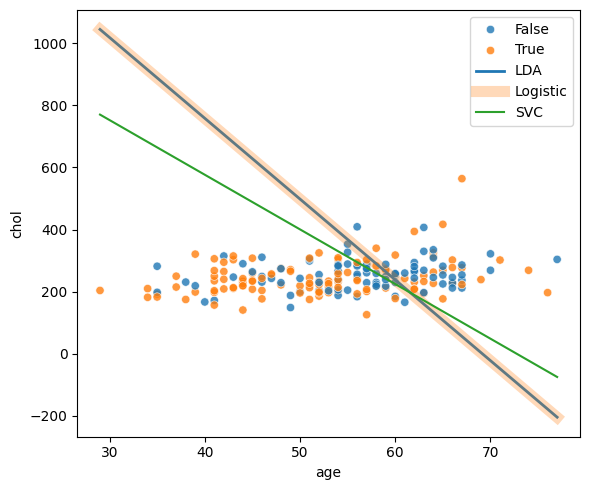

In [162]:
def boundary_fn_for_pipeline(pipe, X_columns=('age','chol')):
    scaler = None
    est = None
    for step in pipe.named_steps.values():
        if hasattr(step, 'mean_') and hasattr(step, 'scale_'):
            scaler = step
        if hasattr(step, 'coef_') and hasattr(step, 'intercept_'):
            est = step
    assert est is not None, "Estimator with coef_ not found (use linear models)."

    i_age = X_columns.index('age')
    i_chol = X_columns.index('chol')

    w = est.coef_[0]
    b = est.intercept_[0]
    w_age, w_chol = w[i_age], w[i_chol]

    if scaler is None:
        return lambda age: -(w_age*age + b)/w_chol
    else:
        mu = scaler.mean_
        sd = scaler.scale_
        return lambda age: (
            mu[i_chol] - sd[i_chol] * (w_age*(age - mu[i_age])/sd[i_age] + b) / w_chol
        )

age_grid = np.linspace(X['age'].min(), X['age'].max(), 200)

chol_lda   = boundary_fn_for_pipeline(lda_pipe,  ['age','chol'])(age_grid)
chol_logit = boundary_fn_for_pipeline(logistic_pipeline,['age','chol'])(age_grid)
chol_svc   = boundary_fn_for_pipeline(best_pipe,['age','chol'])(age_grid)


plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='age', y='chol', hue='disease', alpha=0.8)

plt.plot(age_grid, chol_lda,   label='LDA',lw=2)
plt.plot(age_grid, chol_logit, label='Logistic',lw=8,alpha =0.29)
plt.plot(age_grid, chol_svc,   label='SVC')

plt.xlabel('age'); plt.ylabel('chol'); plt.legend(); plt.tight_layout()
plt.show()


The line for LDA is covered by the logistic model meaning they are the same.